# Implementando el algoritmo LightGBM en Amazon SageMaker

En Amazon SageMaker existen tres modalidades de entrenamiento: algoritmos totalmente manejados, frameworks o algoritmos que soportan script mode y la posibilidad de traer un container propio.

Este último será el caso cuando queramos implementar un modelo de [LightGBM](https://datascience.eu/es/aprendizaje-automatico/que-es-light-gbm/) utilizando el servicio de entrenamiento de SageMaker.

En este artículo vamos a trabajar con el conocido conjunto de datos de Titanic, donde el objetivo es predecir las probabilidades de un pasajero de sobrevivir o no dadas sus características. Para resolver este problema, crearemos un pipeline de inferencia que permita completar datos faltantes, hacer el one hot encoding de las variables categóricas y por último entrenar un modelo predictivo utilizando LightGBM. El código completo de este ejemplo se puede encontrar [aquí](https://github.com/githubmg/sagemaker_lightgbm).

In [11]:
!pip install lightgbm -q

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [70]:
link_csv = "https://github.com/datasciencedojo/datasets/raw/master/titanic.csv"
df = pd.read_csv(link_csv)

In [71]:
df = df.drop(columns = ['PassengerId','Cabin','Ticket','Name'])

In [72]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [78]:
df_train, df_test = train_test_split(df, test_size=0.2)

X = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

In [79]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = [x for x in X.columns if x not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lgbm.LGBMClassifier(n_jobs=-1))])

In [80]:
oof_pred = cross_val_predict(clf, 
                             X, 
                             y, 
                             cv=5,
                             method="predict_proba")

In [81]:
print("Cross validation AUC {:.4f}".format(roc_auc_score(y, oof_pred[:,1])))

Cross validation AUC 0.8631


In [82]:
clf.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [83]:
X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [85]:
y_predict = clf.predict(X_test)

In [87]:
sum(np.array(y_test) == y_predict) / len(y_test)

0.8379888268156425

## Applying Hyperparameter Optimization in LightGBM 

In [88]:
df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)

In [89]:
# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
df['Embarked'].fillna('Null', inplace=True)
embarked_encoder.fit(df['Embarked'])
df['Embarked'] = embarked_encoder.transform(df['Embarked'])

In [90]:
# Transform 'Sex'
df.loc[df['Sex'] == 'female','Sex'] = 0
df.loc[df['Sex'] == 'male','Sex'] = 1
df['Sex'] = df['Sex'].astype('int8')

In [91]:
df_train, df_test = train_test_split(df, test_size=0.2)

X = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

In [92]:
# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgbm.Dataset(data=X, label=y, categorical_feature=categorical_features, free_raw_data=False)

In [93]:
X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [94]:
# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

In [95]:
all_X = df.iloc[:,1:]
all_y = df.iloc[:,0]

In [96]:
# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgbm.Dataset(data=all_X, label=all_y, 
                               categorical_feature=categorical_features, free_raw_data=False)

### Define hyperparameters for LGBM

In [97]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
              }

### Train the model

Use the held out training data to evaluate performance and early stop to control overfitting

In [98]:
evaluation_results = {}
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be 

[LightGBM] [Info] Number of positive: 269, number of negative: 443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377809 -> initscore=-0.498858
[LightGBM] [Info] Start training from score -0.498858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

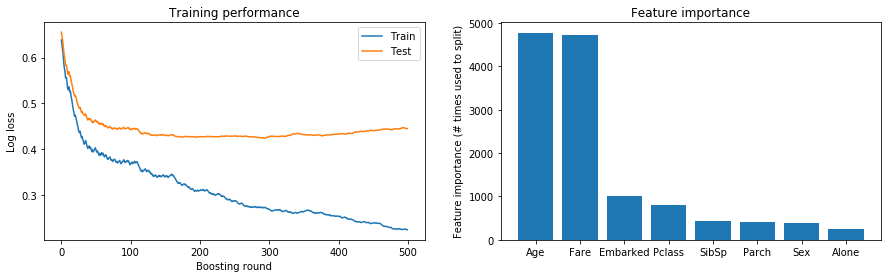

In [99]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

### Examine model performance

Accuracy score can often be misleading for classifiers, so have a look at the precision and recall too

In [118]:
preds = np.round(clf.predict(X_test))
print('Accuracy score: {:.4}'.format(accuracy_score(y_test, preds)))
print('Precision score: {:.4}'.format(precision_score(y_test, preds)))
print('Recall score: {:.4}'.format(recall_score(y_test, preds)))
print('F1 score: {:.4}'.format(f1_score(y_test, preds)))

Accuracy score: 0.8101
Precision score: 0.8679
Recall score: 0.6301
F1 score: 0.7302


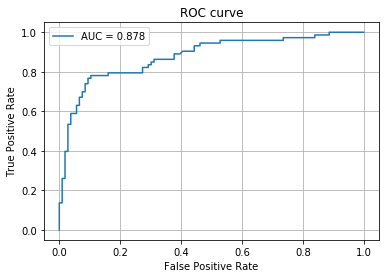

In [122]:
preds_nr = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, preds_nr)
auc_score = roc_auc_score(y_test, preds_nr)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

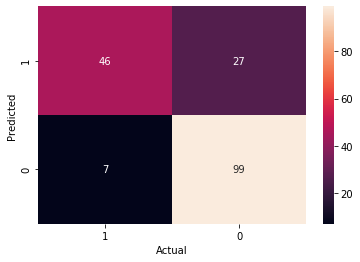

              precision    recall  f1-score   support

           0       0.55      0.66      0.60       106
           1       0.31      0.22      0.26        73

    accuracy                           0.48       179
   macro avg       0.43      0.44      0.43       179
weighted avg       0.45      0.48      0.46       179



In [132]:
classes = [1, 0]
cm = confusion_matrix(y_test, preds, labels=classes)
cmdf = pd.DataFrame(cm, index=classes, columns=classes)
ax = sns.heatmap(cmdf, annot=True)
ax.set(xlabel='Actual', ylabel='Predicted')
plt.show()
print(classification_report(y_test, y_pred))

<img src="https://www.nbshare.io/static/snapshots/cm_colored_1-min.png" style="width:620px;">

### Make predictions on the test set

Using the parameters optimised above, retrain on all the data so we don't miss anything. Then make predictions on the test set.

In [56]:
test_df = df_test.iloc[:,1:]

In [68]:
clf_final = lgbm.train(train_set=final_train_set,
                      params=lgbm_params,
                      #num_boost_round=optimum_boost_rounds,
                      )

y_pred = np.round(clf_final.predict(test_df)).astype(int)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [60]:
y_test = df_test.iloc[:,0]

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0])

In [69]:
sum(np.array(y_test) == y_pred) / len(y_test)

0.8994413407821229